# Enhanced Packet Classification & Anomaly Detection
This notebook loads features from the cleaned packets CSV, trains a classification model using joblib for persistence, validates the model, and detects anomalies in network traffic.

In [322]:
import pandas as pd
import numpy as np
import logging
import json
import os
import joblib
from datetime import datetime
from collections import Counter
import logging
import ipaddress
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

# Configure logging
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(message)s')

# Define constants
RAW_CSV = "captured_packets.csv"
CLEAN_CSV = "cleaned_packets.csv"
MODEL_PATH = "packet_classifier.joblib"
JSON_OUTPUT = "SCAM.json"

In [323]:
# def ip_to_int(ip):
#     try:
#         return int(ipaddress.IPv4Address(str(ip)))
#     except Exception as e:
#         logging.warning(f"Malformed IP: {ip} ({e})")
#         return 0  # fallback for malformed IPs


# def create_cleaned_csv(raw_csv_path="captured_packets.csv", clean_csv_path="cleaned_packets.csv"):
#     if not os.path.exists(raw_csv_path):
#         raise FileNotFoundError(f"Raw CSV file {raw_csv_path} not found!")

#     logging.info(f"Processing raw packet data from {raw_csv_path}")
    
#     try:
#         df_raw = pd.read_csv(raw_csv_path, header=None, engine='python')
#     except Exception as e:
#         raise ValueError(f"Failed to read raw CSV: {e}")

#     logging.info(f"Loaded raw data with {len(df_raw)} rows")

#     df_raw.columns = [
#         'timestamp', 'src_ip', 'dst_ip',
#         'src_port', 'dst_port', 'protocol',
#         'flags', 'length', 'ttl', 'window_size', 'label'
#     ]

#     print("Raw data sample:")
#     print(df_raw.head())

#     df_clean = pd.DataFrame()
#     df_clean['timestamp'] = df_raw['timestamp']
#     df_clean['src_ip'] = df_raw['src_ip'].apply(ip_to_int)
#     df_clean['dst_ip'] = df_raw['dst_ip'].apply(ip_to_int)
#     df_clean['src_port'] = pd.to_numeric(df_raw['src_port'], errors='coerce').fillna(0).astype(int)
#     df_clean['dst_port'] = pd.to_numeric(df_raw['dst_port'], errors='coerce').fillna(0).astype(int)

#     protocol_encoder = LabelEncoder()
#     df_clean['protocol'] = protocol_encoder.fit_transform(df_raw['protocol'].astype(str))
#     joblib.dump(protocol_encoder, 'protocol_encoder.joblib')

#     df_clean['flags'] = df_raw['flags'].apply(
#         lambda x: int(str(x), 16) if str(x).startswith('0x') else x
#     )
#     df_clean['flags'] = pd.to_numeric(df_clean['flags'], errors='coerce').fillna(0).astype(int)

#     df_clean['length'] = pd.to_numeric(df_raw['length'], errors='coerce').fillna(0).astype(int)

#     df_clean['ttl'] = df_raw['ttl'].astype(str).str.replace('**', '', regex=False)
#     df_clean['ttl'] = pd.to_numeric(df_clean['ttl'], errors='coerce').fillna(0).astype(int)

#     df_clean['window_size'] = df_raw['window_size'].astype(str).str.replace('**', '', regex=False)
#     df_clean['window_size'] = pd.to_numeric(df_clean['window_size'], errors='coerce').fillna(0).astype(int)

#     print("Unique labels in raw data:", df_raw['label'].unique())
#     df_clean['label'] = df_raw['label'].astype(str).str.lower().map({"good": 0, "bad": 1})
#     df_clean = df_clean.dropna(subset=['label'])

#     # Remove rows with 0.0.0.0 IPs and "good" label
#     zero_ip = ip_to_int("0.0.0.0")
#     print("Rows before 0.0.0.0 filtering:", df_clean.shape)
#     df_clean = df_clean[~((df_clean['src_ip'] == zero_ip) & (df_clean['label'] == 0))]
#     df_clean = df_clean[~((df_clean['dst_ip'] == zero_ip) & (df_clean['label'] == 0))]

#     df_clean = df_clean.dropna()

#     print("Cleaned data shape:", df_clean.shape)
#     print("Sample cleaned data:")
#     print(df_clean.head())

#     if df_clean.empty:
#         logging.warning("No valid rows after cleaning! CSV will not be saved.")
#         return df_clean

#     try:
#         df_clean.to_csv(clean_csv_path, index=False, encoding='utf-8')
#         print(f"Saved cleaned data to {clean_csv_path}, rows: {len(df_clean)}")
#     except Exception as e:
#         logging.error(f"Failed to write cleaned CSV: {e}")
#         raise

#     return df_clean


## 1. Load the Cleaned Packet Data

In [324]:
import time

CLEAN_CSV = "cleaned_packets.csv"

def load_data(timeout=5):
    if not os.path.exists(CLEAN_CSV):
        raise FileNotFoundError(f"{CLEAN_CSV} not found! Please run data cleaning first.")

    wait_time = 0
    while os.path.getsize(CLEAN_CSV) == 0:
        if wait_time >= timeout:
            raise ValueError(f"{CLEAN_CSV} is still empty after {timeout} seconds! File may not be written correctly.")
        print(f"[wait] {CLEAN_CSV} is empty... waiting 0.5s")
        time.sleep(0.5)
        wait_time += 0.5

    try:
        df = pd.read_csv(CLEAN_CSV)
    except pd.errors.EmptyDataError:
        raise ValueError(f"{CLEAN_CSV} is not readable as CSV (possibly corrupt or blank).")

    logging.info(f"Loaded {len(df)} packets from {CLEAN_CSV}")

    numeric_cols = ['src_ip', 'dst_ip', 'src_port', 'dst_port', 'length', 'ttl', 'window_size', 'protocol', 'flags']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

    # if 'label' in df.columns:
    #     if df['label'].dtype == object:
    #         df['label'] = df['label'].astype(str).str.lower().map({"good": 0, "bad": 1})
    #     df['label'] = pd.to_numeric(df['label'], errors='coerce').fillna(0).astype(int)
        # Map possible_anomaly field to label if present
        if 'possible_anomaly' in df.columns:
            df['label'] = df['possible_anomaly'].astype(str).str.lower().map({'yes': 1, 'no': 0})
            df['label'] = pd.to_numeric(df['label'], errors='coerce').fillna(0).astype(int)
    df.head()
    return df


## 2. Split Data into Training and Test Sets (70/30)

In [325]:
import pandas as pd
df = pd.read_csv("cleaned_packets.csv")  # 
def prepare_data(df):
    """Prepare features and target, split into train/test sets"""
    # Select features and target
    features = ['src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol', 'flags', 'length', 'ttl', 'window_size']
    X = df[features]
    if 'possible_anomaly' in df.columns:
            df['label'] = df['possible_anomaly'].astype(str).str.lower().map({'yes': 1, 'no': 0})
            df['label'] = pd.to_numeric(df['label'], errors='coerce').fillna(0).astype(int)
    y = df['label'] # Assuming 'possible_anomaly' is the target variable still okayyyyyyy
    
    # Split data into 70% training and 30% test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )
    
    logging.info(f"Training set size: {len(X_train)} samples")
    logging.info(f"Test set size: {len(X_test)} samples")
    logging.info(f"Class distribution in training: {Counter(y_train)}")
    logging.info(f"Class distribution in test: {Counter(y_test)}")
    
    return X_train, X_test, y_train, y_test, features

# Prepare the data
X_train, X_test, y_train, y_test, features = prepare_data(df)

[INFO] Training set size: 5170 samples
[INFO] Test set size: 2216 samples
[INFO] Class distribution in training: Counter({0: 4612, 1: 558})
[INFO] Class distribution in test: Counter({0: 1977, 1: 239})


## 3. Train Model with joblib Persistence

In [326]:
def train_and_save_model(X_train, y_train):
    """Train a GradientBoostingClassifier and save using joblib"""
    # Check if model already exists
    if os.path.exists(MODEL_PATH):
        logging.info(f"Loading existing model from {MODEL_PATH}")
        model = joblib.load(MODEL_PATH)
    else:
        logging.info("Training new GradientBoostingClassifier model...")
        model = GradientBoostingClassifier(
            n_estimators=150,
            learning_rate=0.1,
            max_depth=5,
            min_samples_split=5,
            random_state=42
        )
        # Remove existing model file if present before saving new one
        if os.path.exists(MODEL_PATH):
            os.remove(MODEL_PATH)
        model.fit(X_train, y_train)
        #logic
        
        # Save the model
        joblib.dump(model, MODEL_PATH)
        logging.info(f"Model saved to {MODEL_PATH}")
    
    return model

# Train or load the model
model = train_and_save_model(X_train, y_train)

[INFO] Loading existing model from packet_classifier.joblib


## 4. Validate Model Performance

In [327]:
def validate_model(model, X_test, y_test):
    """Validate model performance on the test set"""
    # Make predictions on test set
    y_pred = model.predict(X_test)
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    # Print detailed classification report
    print("\n--- Model Evaluation ---")
    print(classification_report(y_test, y_pred, digits=4))
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': y_pred
    }

# Validate the model
validation_results = validate_model(model, X_test, y_test)


--- Model Evaluation ---
              precision    recall  f1-score   support

           0     0.9598    0.9530    0.9563      1977
           1     0.6324    0.6695    0.6504       239

    accuracy                         0.9224      2216
   macro avg     0.7961    0.8112    0.8034      2216
weighted avg     0.9245    0.9224    0.9233      2216

Accuracy: 0.9224
Precision: 0.6324
Recall: 0.6695
F1 Score: 0.6504


## 5. Predict Anomalies on Full Dataset

In [328]:
def predict_anomalies(model, df, features):
    """Predict anomalies on the full dataset"""
    # Make predictions on the entire dataset
    df['predicted'] = model.predict(df[features])
    
    # Calculate basic statistics
    total_packets = len(df)
    anomalies = df[df['predicted'] == 1]
    total_anomalies = len(anomalies)
    anomaly_percentage = (total_anomalies / total_packets * 100) if total_packets > 0 else 0
    
    logging.info(f"Total packets analyzed: {total_packets}")
    logging.info(f"Total anomalies detected: {total_anomalies} ({anomaly_percentage:.2f}%)")
    
    return df

# Predict anomalies across the full dataset
df_with_predictions = predict_anomalies(model, df, features)

[INFO] Total packets analyzed: 7386
[INFO] Total anomalies detected: 817 (11.06%)


## 6. Generate and Save Summary to JSON

In [329]:
def generate_summary(df, validation_results):
    """Generate comprehensive anomaly detection summary"""
    # Get anomalies
    anomalies = df[df['predicted'] == 1]
    total_packets = len(df)
    total_anomalies = len(anomalies)
    
    # Get IP information from anomalies
    # Convert numeric IPs back to string format for better readability
    def int_to_ip(ip_int):
        try:
            return str(ipaddress.IPv4Address(ip_int))
        except Exception:
            return str(ip_int)
    
    # Convert IPs if they exist in the dataframe
    if 'src_ip' in anomalies.columns:
        src_ips = [int_to_ip(ip) for ip in anomalies['src_ip'].unique()]
    else:
        src_ips = []
        
    if 'dst_ip' in anomalies.columns:
        dst_ips = [int_to_ip(ip) for ip in anomalies['dst_ip'].unique()]
    else:
        dst_ips = []
    
    # Protocol distribution
    protocol_dist = df['protocol'].value_counts().to_dict()
    
    # Extract timestamps if available
    last_seen = None
    if 'timestamp' in anomalies.columns and not anomalies.empty:
        last_seen = str(anomalies['timestamp'].max())
    
    # Create summary dictionary
    summary = {
        "analysis_timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "model_performance": {
            "accuracy": validation_results['accuracy'],
            "precision": validation_results['precision'],
            "recall": validation_results['recall'],
            "f1_score": validation_results['f1_score']
        },
        "anomaly_summary": {
            "total_packets": total_packets,
            "total_anomalies": total_anomalies,
            "anomaly_percentage": (total_anomalies / total_packets * 100) if total_packets > 0 else 0,
            "anomalies_by_type": {"1": total_anomalies},  # Type 1 anomalies as detected by the model
            "source_ips": src_ips,
            "destination_ips": dst_ips,
            "protocol_distribution": protocol_dist,
            "last_anomaly_seen": last_seen
        }
    }
    
    # Save summary to JSON file
    with open(JSON_OUTPUT, 'w') as f:
        json.dump(summary, f, indent=4)
    
    logging.info(f"Anomaly detection summary saved to {JSON_OUTPUT}")
    return summary

# Generate and save the summary
summary = generate_summary(df_with_predictions, validation_results)
print(json.dumps(summary, indent=4))

[INFO] Anomaly detection summary saved to SCAM.json


{
    "analysis_timestamp": "2025-05-19 16:01:15",
    "model_performance": {
        "accuracy": 0.9223826714801444,
        "precision": 0.6324110671936759,
        "recall": 0.6694560669456067,
        "f1_score": 0.6504065040650406
    },
    "anomaly_summary": {
        "total_packets": 7386,
        "total_anomalies": 817,
        "anomaly_percentage": 11.061467641483889,
        "anomalies_by_type": {
            "1": 817
        },
        "source_ips": [
            "223982350",
            "2886795954",
            "2886799005",
            "347974940",
            "2886797292",
            "2886748601",
            "1758466143",
            "2886796038",
            "2886797201",
            "2886798493",
            "2886748210",
            "2886798787",
            "312599876",
            "306430730",
            "577669849",
            "2354213398",
            "2886730274",
            "2886797085",
            "2886796520",
            "2886795585",
            "2886

## 7. Feature Importance Analysis

Note: you may need to restart the kernel to use updated packages.

Feature ranking:
1. window_size (0.6248)
2. src_ip (0.0912)
3. length (0.0846)
4. ttl (0.0825)
5. dst_ip (0.0604)
6. dst_port (0.0377)
7. src_port (0.0175)
8. flags (0.0012)
9. protocol (0.0000)


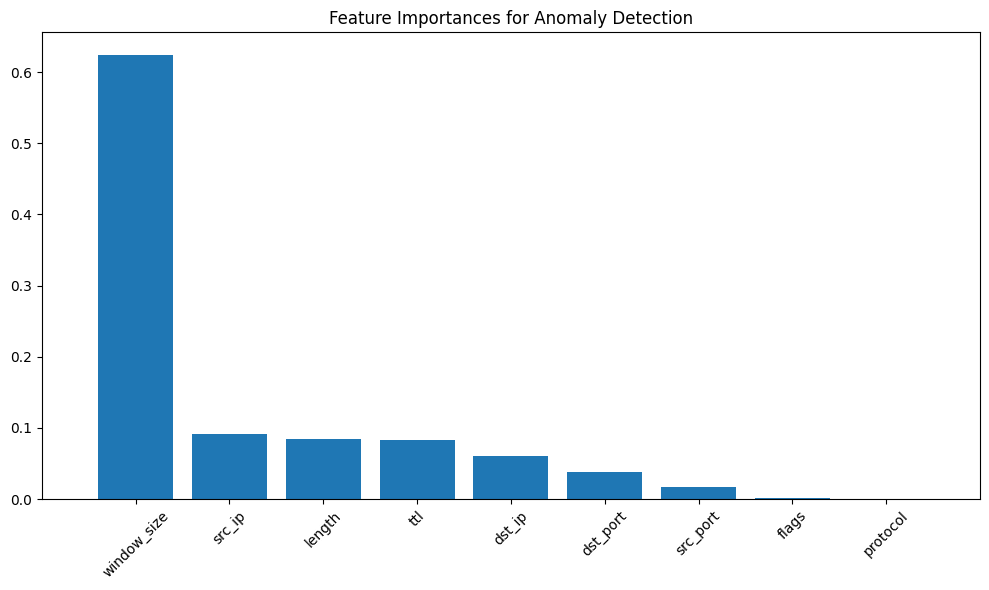

In [330]:
def analyze_feature_importance(model, features):
    """Analyze and visualize feature importance"""

    %pip install matplotlib
    import matplotlib.pyplot as plt
    # Get feature importance from the model
    importances = model.feature_importances_
    
    # Sort feature importances in descending order
    indices = np.argsort(importances)[::-1]
    
    # Print feature ranking
    print("\nFeature ranking:")
    for i, idx in enumerate(indices):
        print(f"{i+1}. {features[idx]} ({importances[idx]:.4f})")
    
    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances for Anomaly Detection")
    plt.bar(range(len(features)), importances[indices], align="center")
    plt.xticks(range(len(features)), [features[i] for i in indices], rotation=45)
    plt.xlim([-1, len(features)])
    plt.tight_layout()
    plt.show()

# Analyze feature importance
analyze_feature_importance(model, features)

## 8. Main Execution Function

[INFO] Loaded 7386 packets from cleaned_packets.csv
[INFO] Training set size: 5170 samples
[INFO] Test set size: 2216 samples
[INFO] Class distribution in training: Counter({0: 4612, 1: 558})
[INFO] Class distribution in test: Counter({0: 1977, 1: 239})
[INFO] Loading existing model from packet_classifier.joblib
[INFO] Total packets analyzed: 7386
[INFO] Total anomalies detected: 817 (11.06%)
[INFO] Anomaly detection summary saved to SCAM.json



--- Model Evaluation ---
              precision    recall  f1-score   support

           0     0.9598    0.9530    0.9563      1977
           1     0.6324    0.6695    0.6504       239

    accuracy                         0.9224      2216
   macro avg     0.7961    0.8112    0.8034      2216
weighted avg     0.9245    0.9224    0.9233      2216

Accuracy: 0.9224
Precision: 0.6324
Recall: 0.6695
F1 Score: 0.6504
Note: you may need to restart the kernel to use updated packages.

Feature ranking:
1. window_size (0.6248)
2. src_ip (0.0912)
3. length (0.0846)
4. ttl (0.0825)
5. dst_ip (0.0604)
6. dst_port (0.0377)
7. src_port (0.0175)
8. flags (0.0012)
9. protocol (0.0000)


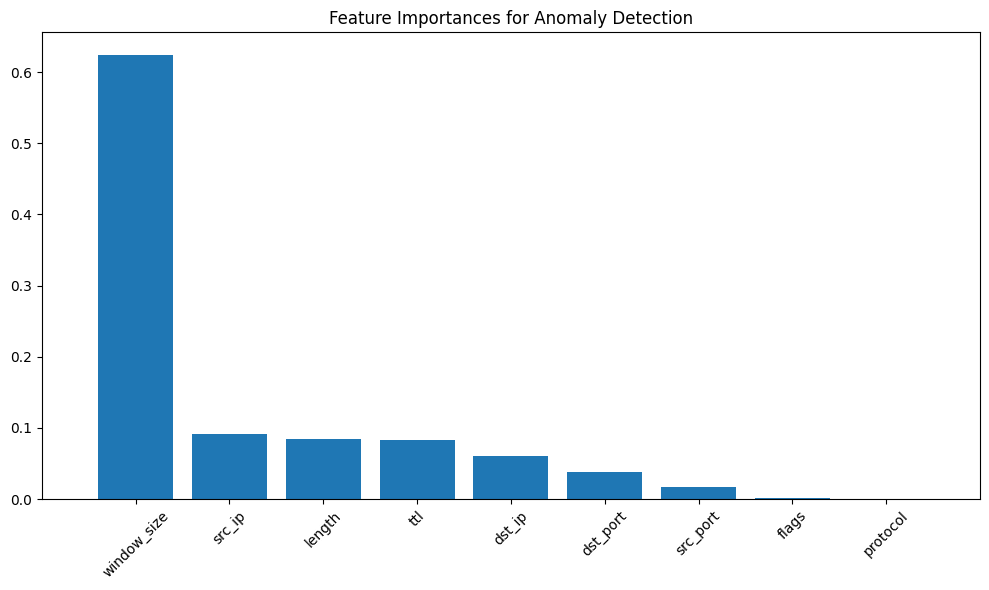

[INFO] Packet classification and anomaly detection completed successfully!


In [331]:
def main():
    """Main function to execute the entire pipeline"""
    try:
        
        # 0. Create cleaned CSV if it doesn't exist or force recreation
        # if not os.path.exists(CLEAN_CSV) :
        #     logging.info("Creating cleaned CSV file...")
        #     df_clean = create_cleaned_csv(RAW_CSV, CLEAN_CSV)
        #     logging.info(f"Created cleaned CSV file: {CLEAN_CSV}")
        # else:
        #     logging.info(f"Using existing cleaned CSV file: {CLEAN_CSV}")
            
        # 1. Load the data
        df = load_data()
        
        # 2. Prepare data and split into train/test
        X_train, X_test, y_train, y_test, features = prepare_data(df)
        
        # 3. Train and save model
        model = train_and_save_model(X_train, y_train)
        
        # 4. Validate model
        validation_results = validate_model(model, X_test, y_test)
        
        # 5. Predict anomalies on full dataset
        df_with_predictions = predict_anomalies(model, df, features)
        
        # 6. Generate summary
        summary = generate_summary(df_with_predictions, validation_results)
        
        # 7. Feature importance
        analyze_feature_importance(model, features)
        
        return True
    except Exception as e:
        logging.error(f"Error in pipeline: {e}")
        return False

# Execute the main function when running the notebook
if __name__ == "__main__":
    success = main()
    if success:
        logging.info("Packet classification and anomaly detection completed successfully!")
    else:
        logging.error("Packet classification and anomaly detection failed!")

In [332]:
#time complexity ka kuch karna hai daa ke liye
